In [4]:
%pip install seaborn
# To avoid the deprecation warning
%pip install pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<ipython-input-4-42c36d0ed1cb>:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# Import Datasets
launches = pd.read_csv('Launches.csv')
configs = pd.read_csv('Configs.csv')
families = pd.read_csv('Families.csv')
companies = pd.read_csv('Companies.csv')
locations = pd.read_csv('Locations.csv')
missions = pd.read_csv('Missions.csv')

As our dataset is split up between 6 csv files, the dataframe must combine the data from them. For that, we will use joins and, for them to work, the data types must be correctly aligned.

In [6]:
configs['Family Id'] = configs['Family Id'].astype(int)

rockets = pd.merge(configs, families, how = 'inner', on = 'Family Id')

launch_data = pd.merge(launches, locations, how = 'inner', left_on = 'Location', right_on = 'Orig_Addr')
launch_data = pd.merge(launch_data, rockets, how = 'inner', right_on = 'Config', left_on = 'Rocket Name')
launch_data = pd.merge(launch_data, companies, how = 'inner', left_on = 'Rocket Organisation', right_on = 'Company Name')
launch_data = pd.merge(launch_data, missions, how = 'inner', on = 'Launch Id')

Let's now consider the dataset info and all feature present after the merger.

In [21]:
launch_data.dropna(inplace=True)
launch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1887 entries, 0 to 6354
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Launch Id                   1887 non-null   int64  
 1   Launch Time                 1887 non-null   object 
 2   Launch Status               1887 non-null   object 
 3   Launch Suborbital           1887 non-null   object 
 4   Rocket Name                 1887 non-null   object 
 5   Rocket Organisation         1887 non-null   object 
 6   Rocket Price                1887 non-null   float64
 7   Rocket Payload to LEO       1887 non-null   float64
 8   Location                    1887 non-null   object 
 9   Launch Year                 1887 non-null   int64  
 10  Launch Year Mon             1887 non-null   object 
 11  USD/kg to LEO               1887 non-null   float64
 12  2021 Mult                   1887 non-null   float64
 13  USD/kg to LEO CPI Adjusted  1887 non-n

As the plot shows, we have a very imbalanced dataset when considering this specific fields. In order to lower its impact, there are a few approaches that can be taken into consiration. In this instance, we decided to go for under-sampling.

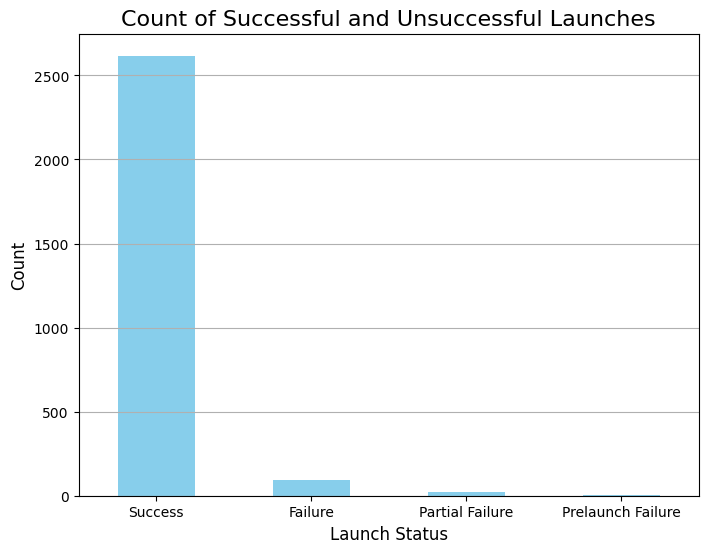

In [28]:
# Count the number of successful and unsuccessful launches
status_counts = launch_data['Launch Status'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## Following the first question: does the price influence the success of a Launch?

### Let's follow a Hypothesis Testing.

### Hypothesis
1) Null Hypothesis (Ho): Price has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): Price influences positively the success of a launch. (Is there a correlation?)

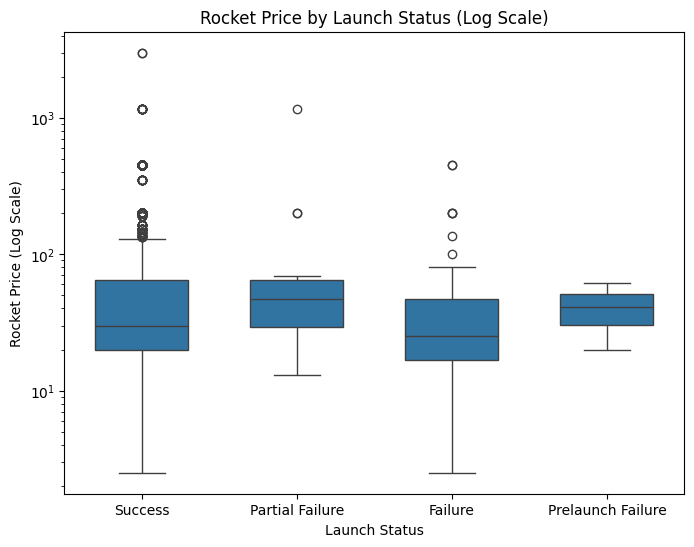

In [30]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.boxplot(x='Launch Status', y='Rocket Price', data=launch_data, width=0.6)
plt.yscale('log') 
plt.title('Rocket Price by Launch Status (Log Scale)')
plt.xlabel('Launch Status')
plt.ylabel('Rocket Price (Log Scale)')
plt.show()

The pairplot visualization suggests that rocket price is not a decisive factor in determining launch success, as failures happen across all price ranges.

In [18]:
import numpy as np
import statsmodels.api as sm

# Converting all the success values to binary values. 
# 1 means Success. 0 means not Success (Failure).
launch_data['Success_Binary'] = (launch_data['Launch Status'] == 'Success').astype(int)

# Redefine X and y
X = launch_data[['Rocket Price']]
X = sm.add_constant(X)
y = launch_data['Success_Binary']

# Fit logistic regression
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.182498
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         Success_Binary   No. Observations:                 2740
Model:                          Logit   Df Residuals:                     2738
Method:                           MLE   Df Model:                            1
Date:                Tue, 17 Dec 2024   Pseudo R-squ.:                0.003760
Time:                        21:17:51   Log-Likelihood:                -500.04
converged:                       True   LL-Null:                       -501.93
Covariance Type:            nonrobust   LLR p-value:                   0.05203
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.9392      0.111     26.439      0.000       2.721       3.157
Rocket Price     0.0018

## Following the second question: Is there any corporation more likely to succeed in a launch??

In [84]:
success_rate = (
    launch_data.groupby('Rocket Organisation')['Success_Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate', 'Total Launches'], ascending=[False, False])

success_rate.head()

,Total Launches,Successful Launches,Success Rate
Rocket Organisation,,,
ULA,47,47,1.000000
Starsem,27,27,1.000000
CASC,252,246,0.976190
SpaceX,118,115,0.974576
RVSN USSR,658,640,0.972644


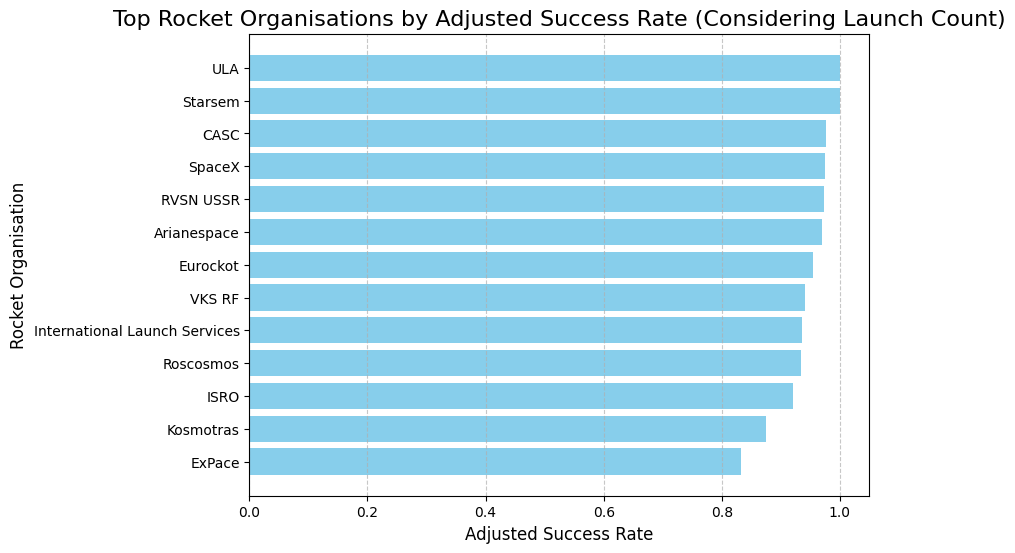

In [85]:
plt.figure(figsize=(8, 6))
plt.barh(success_rate.index, success_rate['Success Rate'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top Rocket Organisations by Adjusted Success Rate (Considering Launch Count)', fontsize=16)
plt.xlabel('Adjusted Success Rate', fontsize=12)
plt.ylabel('Rocket Organisation', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


#we should take in consideration the amount of launches. ULA wins in this approach with 47 launches, where SPACEX loses with hundreds of launches